# Convolutional Neural Networks

This notebook introduces convolutional neural networks (CNNs), a more powerful classification model similar to the Neural Bag-of-Words (BOW) model you explored earlier.

## Outline

- **Part (a):** Model Architecture
- **Part (b):** Implementing the CNN Model
- **Part (c):** Tuning

In [1]:
from __future__ import division
import os, sys, re, json, time, datetime, shutil
import itertools, collections
from importlib import reload
from IPython.display import display, HTML

# NLTK for NLP utils and corpora
import nltk

# NumPy and TensorFlow
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# Helper libraries
from w266_common import utils, vocabulary, tf_embed_viz, treeviz
from w266_common import patched_numpy_io
# Code for this assignment
import sst

# Monkey-patch NLTK with better Tree display that works on Cloud or other display-less server.
print("Overriding nltk.tree.Tree pretty-printing to use custom GraphViz.")
treeviz.monkey_patch(nltk.tree.Tree, node_style_fn=sst.sst_node_style, format='svg')

Overriding nltk.tree.Tree pretty-printing to use custom GraphViz.


## (a) Model Architecture

CNNs are a more sophisticated neural model for sentence classification than the Neural BOW model we saw in the last section. CNNs operate by sweeping a collection of filters over a text. Each filter produces a sequence of feature values known as a _feature map_. In one of the most basic formulations introduced by [Kim (2014)](https://www.aclweb.org/anthology/D14-1181), a single layer of _pooling_ is used to summarize the _feature maps_ as a fixed length vector. The fixed length vector is then feed to the output layer in order to produce classification labels. A popular choice for the pooling operation is to take the maximum feature value from by each _feature map_.

![Convolutional Neural Network from Kim 2014](kim_2014_figure_1_cnn.png)
*CNN model architure, Figure 1 from Kim (2014)*

We'll use the following notation:
- $w^{(i)} \in \mathbb{Z}$, the word id for the $i^{th}$ word of the sequence (as an integer index)
- $x^{(i)} \in \mathbb{R}^d$ for the vector representation (embedding) of $w^{(i)}$
- $x^{i:i+j}$ is the concatenation of $x^{(i)}, x^{(i+1)} ... x^{(i+j)}$ 
- $c^{(i)}_{k}$ is the value of the $k^{th}$ feature map along the word sequence, each filter applies over a window of $h$ words and uses non-linearity $f$.
- $\hat{c}_{k}$ is the value of the $k^{th}$ feature after pooling the feature map over the whole sequence.
- $\hat{C}$ is the concatenation of pooled feature maps. 
- $y$ for the target label ($\in 1,\ldots,\mathtt{num\_classes}$)

Our model is defined as:
- **Embedding layer:** $x^{(i)} = W_{embed}[w^{(i)}]$
- **Convolutional layer:** $c^{(i)}_{k} = f(x^{i:i+h-1} W_k + b)$
- **Pooling layer:**  $\hat{c}_{k}$ = $max(c^{(0)}_{k}, c^{(1)}_{k}...)$ 
- **Output layer:** $\hat{y} = \hat{P}(y) = \mathrm{softmax}(\hat{C} W_{out} + b_{out})$


We'll refer to the first part of this model (**Embedding layer**, **Convolutional layer**, and **Pooling layer**) as the **Encoder**: it has the role of encoding the input sequence into a fixed-length vector representation that we pass to the output layer.

We'll also use these as shorthand for important dimensions:
- `V`: the vocabulary size (equal to `ds.vocab.size`)
- `N`: the maximum number of tokens in the input text
- `embed_dim`: the embedding dimension $d$
- `kernel_size`: a list of filter lengths
- `filters`: number filters per filter length
- `num_classes`: the number of target classes (2 for the binary task)

## (a) Short Answer Questions

When answering these questions in the answers file,
`embed_dim = 10`, `kernel_size = [3, 4, 5]`, `filters=128`, `N=10` and `num_classes = 7`.

1. In terms of these values, the vocabulary size `V` and the maximum sequence length `N`, what are the
   shapes of the following variables: 
   $c^{(i)}_{kernal\_size=3}$, $c^{(i)}_{kernal\_size=4}$, $c^{(i)}_{kernal\_size=5}$, $\hat{c}^{(i)}_{kernal\_size=3}$, $\hat{c}^{(i)}_{kernal\_size=4}$, $\hat{c}^{(i)}_{kernal\_size=5}$, and $\hat{C}$. Assume a stride size of 1. Assume padding is not used (e.g., for tf.nn.max_pool and tf.nn.conv1d, setting padding='VALID'), provide the shapes listed above.
<p>
2. What are the shapes of $c^{(i)}_{kernal\_size=3}$ and $\hat{c}^{(i)}_{kernal\_size=3}$ when paddiding is used.
      (e.g., for tf.nn.max_pool and tf.nn.conv1d, setting padding='same').
<p>
3. How many parameters are in each of the convolutional filters, $W_{filter\_length=3}$, $W_{filter\_length=4}$, $W_{filter\_length=5}$? And the output layer, $W_{out}$?
<p>
<p>
4. Historically NLP models made heavy use of manual feature engineering. In relation to systems with manually engineered features, describe what type of operation is being performed by the convolutional filters.
<p>
5. Suppose that we have two examples, `[foo bar baz]` and `[baz bar foo]`. Will this model make the same predictions on these? Why or why not?

## (b) Implementing the CNN Model

We'll implement our CNN model below. Our implementation will differ from [Kim (2014)](https://www.aclweb.org/anthology/D14-1181) in that we will support using multiple dense hidden layers after the convolutional layers.

**Before you start**, be sure to answer the short-answer questions above!

In [2]:
import sst

# Load SST dataset
ds = sst.SSTDataset(V=20000).process(label_scheme="binary")
max_len = 40
train_x, train_ns, train_y = ds.as_padded_array('train', max_len=max_len, root_only=True)
dev_x,   dev_ns,   dev_y   = ds.as_padded_array('dev',   max_len=max_len, root_only=True)
test_x,  test_ns,  test_y  = ds.as_padded_array('test',  max_len=max_len, root_only=True)

Loading SST from data/sst/trainDevTestTrees_PTB.zip
Training set:     8,544 trees
Development set:  1,101 trees
Test set:         2,210 trees
Building vocabulary - 16,474 words
Processing to phrases...  Done!
Splits: train / dev / test : 98,794 / 13,142 / 26,052


In [14]:
# Specify model hyperparameters.
epochs = 10
embed_dim = 5
num_filters = [2, 2, 2]
kernel_sizes = [2, 3, 4]
dense_layer_dims = []
dropout_rate = 0.8
num_classes = len(ds.target_names)

# Construct the convolutional neural network.
# The form of each keras layer function is as follows:
#    result = keras.layers.LayerType(arguments for the layer)(layer(s) it should use as input)
# concretely,
#    this_layer_output = keras.layers.Dense(100, activation='relu')(prev_layer_vector)
# performs this_layer_output = relu(prev_layer_vector x W + b) where W has 100 columns.

# Input is a special "layer".  It defines a placeholder that will be overwritten by the training data.
# In our case, we are accepting a list of wordids (padded out to max_len).
wordids = keras.layers.Input(shape=(max_len,))

# Embed the wordids.
# Recall, this is just a mathematically equivalent operation to a linear layer and a one-hot
h = keras.layers.Embedding(ds.vocab.size, embed_dim, input_length=max_len)(wordids)

# Construct "filters" randomly initialized filters with dimension "kernel_size" for each size of filter we want.
# With the default hyperparameters, we construct 10 filters each of size 2, 3, 4.  As in the image above, each filter
# is wide enough to span the whole word embedding (this is why the convolution is "1d" as seen in the
# function name below).
conv_layers_for_all_kernel_sizes = []
for kernel_size, filters in zip(kernel_sizes, num_filters):
    conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(h)
    conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
    conv_layers_for_all_kernel_sizes.append(conv_layer)
    
# Concat the feature maps from each different size.
h = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)

# Dropout can help with overfitting (improve generalization) by randomly 0-ing different subsets of values
# in the vector.
# See https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf for details.
h = keras.layers.Dropout(rate=dropout_rate)(h)
### YOUR CODE HERE

# Add a fully connected layer for each dense layer dimension in dense_layer_dims.
for dim in dense_layer_dims:
    h = keras.layers.Dense(dim,activation='relu')(h)
### END YOUR CODE

prediction = keras.layers.Dense(num_classes, activation='softmax')(h)

model = keras.Model(inputs=wordids, outputs=prediction)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # From information theory notebooks.
              metrics=['accuracy'])        # What metric to output as we train.

In [17]:
model.reset_states()
model.fit(train_x, train_y, epochs=epochs)

Epoch 1/10
6920/6920 [==============================] - 1s 82us/sample - loss: 0.3997 - acc: 0.7698
Epoch 2/10
6920/6920 [==============================] - 1s 74us/sample - loss: 0.3945 - acc: 0.7773
Epoch 3/10
6920/6920 [==============================] - 1s 78us/sample - loss: 0.3898 - acc: 0.7801
Epoch 4/10
6920/6920 [==============================] - 1s 79us/sample - loss: 0.4015 - acc: 0.7710
Epoch 5/10
6920/6920 [==============================] - 1s 77us/sample - loss: 0.3952 - acc: 0.7749
Epoch 6/10
6920/6920 [==============================] - 1s 74us/sample - loss: 0.4040 - acc: 0.7686
Epoch 7/10
6920/6920 [==============================] - 1s 73us/sample - loss: 0.3991 - acc: 0.7721
Epoch 8/10
6920/6920 [==============================] - 1s 74us/sample - loss: 0.4022 - acc: 0.7697
Epoch 9/10
6920/6920 [==============================] - 1s 76us/sample - loss: 0.4018 - acc: 0.7704
Epoch 10/10
6920/6920 [==============================] - 1s 74us/sample - loss: 0.3922 - acc: 0.7789

## Evaluation

Call [evaluate](https://keras.io/models/model/#evaluate) on your model.

In [18]:
#### YOUR CODE HERE ####
print("---Evaluating on dev data set---")
model.evaluate(dev_x,dev_y,verbose=1)
print("\n---Evaluating on test data set---")
model.evaluate(test_x,test_y,verbose=1)
#### END(YOUR CODE) ####

---Evaluating on dev data set---
872/872 [==============================] - 0s 107us/sample - loss: 0.9727 - acc: 0.6938

---Evaluating on test data set---
1821/1821 [==============================] - 0s 28us/sample - loss: 0.9370 - acc: 0.6886


[0.9369868661989424, 0.6886326]

# Part (c): Tuning Your Model

We'll once again want to optimize hyperparameters for our model to see if we can improve performance. The CNN model includes a number of new parameters that can significantly influence model performance.

In this section, you will be asked to describe the new parameters as well as use them to attempt to improve the performance of your model.

## Part (c) Short Answer Questions

  1. Choose two parameters unique the CNN model, perform at least 10 runs with different combinations of values for these parameters, and then report the dev set results below. ***Hint: Consider wrapping the training code above in a for loop the examines the different values.***  To do this efficiently, you should consider [this paper](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) from Bergstra and Bengio.  [This blog post](https://blog.floydhub.com/guide-to-hyperparameters-search-for-deep-learning-models/) also has a less formal treatment of the same topic.
  2. Describe any trends you see in experiments above (e.g., can you identify good ranges for the individual parameters; are there any interesting interactions?)
  3. Pick the three best configurations according to the dev set and evaluate them on the test data. Is the ranking of the three best models the same on the dev and test sets?
  4. What was the best accuracy you achieved on the test set?

In [19]:
# Define a module for the network architecture
def create_model(kernel_sizes=[2,3,4],num_filters=[2,2,2],dense_layer_dims=[]):
    wordids = keras.layers.Input(shape=(max_len,))
    h = keras.layers.Embedding(ds.vocab.size, embed_dim, input_length=max_len)(wordids)
    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(h)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)
    h = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    h = keras.layers.Dropout(rate=dropout_rate)(h)
    for dim in dense_layer_dims:
        h = keras.layers.Dense(dim,activation='relu')(h)
    predictions = keras.layers.Dense(num_classes, activation='softmax')(h)
    model = keras.Model(inputs=wordids, outputs=predictions)
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy'])  
    return model

Choose the following parameters for tuning the neural network:
- Number of filters for each kernel size
- Filter kernel size


In [25]:
epochs = 20
dev_losses = []
dev_accuracies = []
dense_layer_dims = [10]                           # Fully connected layers before softmax

# ---------------- Hyper parameters for tuning the network ------------------------------------------ 
total_kernel_sizes = ([3,4,5],[3,4,5,6],[4,5,6],[4,5,6,7])  # Kernel sizes 
total_filter_range = range(7,20)                            # Number of total filter per kernel size
# ---------------------------------------------------------------------------------------------------
num_iterations = len(total_kernel_sizes)*len(total_filter_range)
iteration = 0
with tf.Session(config=tf.ConfigProto(log_device_placement=True,inter_op_parallelism_threads=12,intra_op_parallelism_threads=12)) as sess:
    for kernel_sizes in total_kernel_sizes:      # Loop over kernel sizes 
        for total_filters in total_filter_range: # Loop over number of filters for each kernel
            iteration+=1
            start_time = time.time()
            num_filters = [total_filters,total_filters,total_filters]  # Using same number of filters for each kernel for now
            model= create_model(kernel_sizes,num_filters,dense_layer_dims)
            model.reset_states()
            model.fit(train_x, train_y, epochs=epochs,verbose=0,batch_size = 128, validation_data=(dev_x,dev_y))
            loss, acc = model.evaluate(dev_x,dev_y,verbose=0)
            print('---Iteration ', iteration, 'of', num_iterations)
            print('Kernel Sizes:', kernel_sizes, '| Number of filters:',total_filters,'| Dev Loss:',loss,'| Accuracy:',acc)
            dev_losses.append(loss)
            dev_accuracies.append(acc)
            print('Execution Time: %0.4f seconds'% (time.time() - start_time))
            print('-'*110)
            

---Iteration  1 of 52
Kernel Sizes: [3, 4, 5] | Number of filters: 7 | Dev Loss: 0.8222532086416122 | Accuracy: 0.73509175
Execution Time: 10.2120 seconds
--------------------------------------------------------------------------------------------------------------
---Iteration  2 of 52
Kernel Sizes: [3, 4, 5] | Number of filters: 8 | Dev Loss: 1.0970925169253567 | Accuracy: 0.7201835
Execution Time: 10.5804 seconds
--------------------------------------------------------------------------------------------------------------
---Iteration  3 of 52
Kernel Sizes: [3, 4, 5] | Number of filters: 9 | Dev Loss: 0.9818469663278773 | Accuracy: 0.73279816
Execution Time: 10.6822 seconds
--------------------------------------------------------------------------------------------------------------
---Iteration  4 of 52
Kernel Sizes: [3, 4, 5] | Number of filters: 10 | Dev Loss: 0.9581460865265733 | Accuracy: 0.7305046
Execution Time: 10.8957 seconds
------------------------------------------------

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f935768f0f0>>
Traceback (most recent call last):
  File "/home/suhasgupta/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/suhasgupta/.local/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f935768b6a0>>
Traceback (most recent call last):
  File "/home/suhasgupta/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/suhasgupta/.local/lib/

---Iteration  7 of 52
Kernel Sizes: [3, 4, 5] | Number of filters: 13 | Dev Loss: 1.2458213819276303 | Accuracy: 0.70298165
Execution Time: 12.6228 seconds
--------------------------------------------------------------------------------------------------------------
---Iteration  8 of 52
Kernel Sizes: [3, 4, 5] | Number of filters: 14 | Dev Loss: 1.1026166305629486 | Accuracy: 0.7396789
Execution Time: 12.9826 seconds
--------------------------------------------------------------------------------------------------------------
---Iteration  9 of 52
Kernel Sizes: [3, 4, 5] | Number of filters: 15 | Dev Loss: 0.932551706602814 | Accuracy: 0.76490825
Execution Time: 13.2417 seconds
--------------------------------------------------------------------------------------------------------------
---Iteration  10 of 52
Kernel Sizes: [3, 4, 5] | Number of filters: 16 | Dev Loss: 1.0060493967948703 | Accuracy: 0.728211
Execution Time: 13.2469 seconds
----------------------------------------------

---Iteration  38 of 52
Kernel Sizes: [4, 5, 6] | Number of filters: 18 | Dev Loss: 1.3057621279987721 | Accuracy: 0.6995413
Execution Time: 23.2944 seconds
--------------------------------------------------------------------------------------------------------------
---Iteration  39 of 52
Kernel Sizes: [4, 5, 6] | Number of filters: 19 | Dev Loss: 1.0650091709893779 | Accuracy: 0.7087156
Execution Time: 23.5558 seconds
--------------------------------------------------------------------------------------------------------------
---Iteration  40 of 52
Kernel Sizes: [4, 5, 6, 7] | Number of filters: 7 | Dev Loss: 0.7556764778740909 | Accuracy: 0.7706422
Execution Time: 23.8333 seconds
--------------------------------------------------------------------------------------------------------------
---Iteration  41 of 52
Kernel Sizes: [4, 5, 6, 7] | Number of filters: 8 | Dev Loss: 1.1713126241613965 | Accuracy: 0.7178899
Execution Time: 24.1983 seconds
---------------------------------------

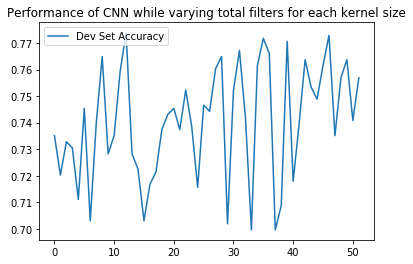

[0.77408254, 0.7729358, 0.771789]

In [27]:
import matplotlib.pyplot as plt
hyper_iter = range(len(total_filter_range)*len(total_kernel_sizes))
plt.plot(hyper_iter,dev_accuracies,label='Dev Set Accuracy')
#plt.plot(dev_losses,label='Dev Set Loss')
plt.legend()
plt.title("Performance of CNN while varying total filters for each kernel size")
plt.show()

# Print top three configs
idx = np.argsort(dev_accuracies)[::-1][:3]
[dev_accuracies[i] for i in idx]

#### Pick top three configurations and evaluate on test data


- Best Config     : Kernel Sizes =[4,5,6,7]. Number of filters per kernel = 14
- 2nd Best Config : Kernel Sizes =[3,4,5]. Number of filters per kernel = 19
- 3rd Best Config : Kernel Sizes =[4,5,6]. Number of filters per kernel = 16

In [28]:
total_kernel_sizes = [[4,5,6,7],[3,4,5],[4,5,6]] # Pick the best kernel size and number config
total_filter_range = [14,19,16] # Pick the top three filter numbers in descending order of accuracy

epochs = 20
dense_layer_dims=[10]
dev_losses = []
dev_accuracies = []
test_losses = []
test_accuracies = []
import time 

# Train model and evaluate (tensorflow config already set to use CUDA GPU on this machine)
with tf.Session(config=tf.ConfigProto(log_device_placement=True,inter_op_parallelism_threads=12,intra_op_parallelism_threads=12)) as sess:
    for kernel_sizes,total_filters in zip(total_kernel_sizes,total_filter_range):
        start_time = time.time()
        num_filters = [total_filters,total_filters,total_filters]  # Using same number of filters for each kernel for now
        model= create_model(kernel_sizes,num_filters,dense_layer_dims)
        model.reset_states()
        model.fit(train_x, train_y, epochs=epochs,verbose=0,batch_size = 128)
        dev_loss, dev_acc = model.evaluate(dev_x,dev_y,verbose=0)
        dev_losses.append(dev_loss)
        dev_accuracies.append(dev_acc)
        test_loss, test_acc = model.evaluate(test_x,test_y,verbose=0)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        print('Kernel Sizes:', kernel_sizes, '| Number of filters:',total_filters)
        print('Dev Loss:',dev_loss,'| Dev Accuracy:',dev_acc, '| Test Loss:',test_loss,'| Test Accuracy:',test_acc)
        print('Execution Time: %0.4f seconds'% (time.time() - start_time))
        print('-'*115)


Kernel Sizes: [4, 5, 6, 7] | Number of filters: 14
Dev Loss: 0.9167712139427115 | Dev Accuracy: 0.76490825 | Test Loss: 0.8761989640246899 | Test Accuracy: 0.752883
Execution Time: 35.5000 seconds
-------------------------------------------------------------------------------------------------------------------
Kernel Sizes: [3, 4, 5] | Number of filters: 19
Dev Loss: 1.1482769972687468 | Dev Accuracy: 0.72477067 | Test Loss: 1.1759545849549253 | Test Accuracy: 0.72048324
Execution Time: 37.1177 seconds
-------------------------------------------------------------------------------------------------------------------
Kernel Sizes: [4, 5, 6] | Number of filters: 16
Dev Loss: 0.9766368946624459 | Dev Accuracy: 0.76376146 | Test Loss: 0.9601195130552452 | Test Accuracy: 0.7660626
Execution Time: 36.9032 seconds
-------------------------------------------------------------------------------------------------------------------


When evaluated on the test dataset, config 3 gives the best accuracy and loss which is oppostie of the evaluation done on the dev dataset. This indicates that the model is overfitting the dev data set. It is worthwhile to note that the confg1 (best config on dev set) has an accuracy quite close to the config 3(best config from test set).

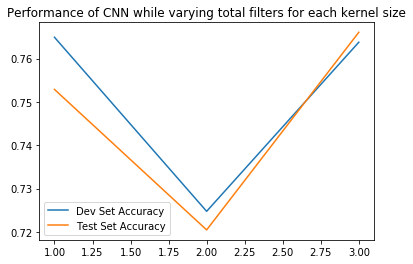

In [29]:
hyper_iter = range(1,4)
plt.plot(hyper_iter,dev_accuracies,label='Dev Set Accuracy')
plt.plot(hyper_iter,test_accuracies,label='Test Set Accuracy')
plt.legend()
plt.title("Performance of CNN while varying total filters for each kernel size")
plt.show()